## Experimenting with Parameters
    In this notebook, we will experiment with different values for learning rate, discount rate, max_exploration_rate, min_exploration_rate, and exploration_decay_rate to analyze how the learning curve can get affected by this.

In [1]:
import numpy as np
import gym
import random
import time
from IPython.display import clear_output
from matplotlib import pyplot as plot
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class State:
    def __init__(self, x, y):
        self.x = x
        self.y = y

up = lambda state: State(state.x, state.y-1)
down = lambda state: State(state.x, state.y+1)
left = lambda state: State(state.x - 1, state.y)
right = lambda state: State(state.x + 1, state.y)
action_space_size = 4
state_space_size = 63
action_space = [up, down, left, right]

def get_sample():
    random_pos = np.random.randint(0,4)
    return action_space[random_pos], random_pos

def get_num_state(state):
    return state.y*9 + state.x

def reset():
    initial_state = State(1,1)
    return initial_state,get_num_state(initial_state)

def is_goal_state(state):
    return state.x == 7 and state.y == 4

def get_reward(state):
    if state.x not in range(9) or state.y not in range(7):
        return -10
    if is_goal_state(state):
        return 126
    return -1

def rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate):
    # This cycle is to calculate the average reward/episodes and its only purpose is to plot the nice graph below that
# shows how the agent learns to maximize the reward.
    rewards_avg = []
    q_table_avg = []
    num_times_goal_reached_avg = []
    for it in range(100):
        #print('average ', it)
        rewards_all_episodes=[]
        q_table_all_episodes = []
        num_times_goal_reached = 0
       # num_episodes_reward_treshold_avg = -1
        # exporation-exploitation trade-off params
        exploration_rate = 1

        # init q table in zeros
        q_table = np.zeros((state_space_size, action_space_size))

        # iterate over the episodes
        for episode in range(num_episodes):
            state, num_state = reset()
            done = False
            rewards_current_episode = 0

            # iterate over the steps for an episode
            for step in range(max_steps_per_episode):
                # Exploration-exploitation trade-off
                exploration_rate_threshold = np.random.random()
                if exploration_rate_threshold <= exploration_rate:
                    action, pos_action = get_sample()
                else:
                    q_row = q_table[num_state]
                    pos_action = np.where(q_row == max(q_row))[0][0]
                    action = action_space[pos_action]
                # Take action
                new_state, reward, done = move_without_wind(state, action)
                if new_state == None:
                    num_new_state = get_num_state(state)
                else:
                    num_new_state = get_num_state(new_state)
                # Update Q-table for Q(s,a)
                max_value = max(q_table[num_new_state])
                future_q=learning_rate*(reward + discount_rate*max_value)
                q_table[num_state, pos_action] = (1-learning_rate)*q_table[num_state,pos_action] + future_q

                # transition next state
                state = new_state
                num_state = num_new_state
                rewards_current_episode += reward
                        
                if done == True: 
                    break

            # Exploration rate decay
            exploration_rate = min_exploration_rate + (max_exploration_rate-min_exploration_rate) * np.exp(-exploration_decay_rate*episode)
            
            if state!=None and is_goal_state(state):
                num_times_goal_reached += 1
                
            rewards_all_episodes.append(rewards_current_episode)
            q_table_all_episodes.append(q_table)
            
        num_times_goal_reached_avg.append(num_times_goal_reached)        
        rewards_avg.append(rewards_all_episodes)
        q_table_avg.append(q_table_all_episodes)
    return rewards_avg, q_table, num_times_goal_reached_avg
        
def plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath):
    x = [i for i in range(0,num_episodes)]
    y = np.mean(rewards_avg, axis=0)
    plot.xlabel('Episodes')
    plot.ylabel('Reward')
    plot.plot(x, y,'o')
    plot.title("Episodes_vs_Rewards")
    plt.savefig(filepath)
    plt.show()
    
def get_state_actions(q_table):
    q_table_best_actions =[]
    for i in range(q_table.shape[0]):
        max_pos = np.argmax(q_table[i])
        q_table_best_actions.append(max_pos)
    return q_table_best_actions
    
def plot_optimal_policy(q_table, filepath):
    w = 0.3
    i,j=0,0
    best_actions_matrix = np.array(get_state_actions(q_table)).reshape(7,9)
    arrow_dict = {0:lambda i,j:plt.arrow(x=i, y=j-0.25, dx=0, dy=w, width=.05)  ,1:lambda i,j:plt.arrow(x=i, y=j+0.25, dx=0, dy=-w, width=.05),2:lambda i,j:plt.arrow(x=i+0.2, y=j, dx=-w, dy=0, width=.05),3:lambda i,j:plt.arrow(x=i-0.2, y=j, dx=w, dy=0, width=.05)}
    arrow_matrix=np.transpose(np.array(best_actions_matrix).reshape(7,9))
    for j in range(len(arrow_matrix)):
        for i in range(len(arrow_matrix[j])):
            arrow_dict[best_actions_matrix[i,j]](j+0.5,(6-i)+0.5)
    start = [1,1]
    goal = [7,4]
    plt.scatter(start[0]+0.5,6-start[1]+0.5, color="green", linewidths=20)
    plt.scatter(goal[0]+0.5,6-goal[1]+0.5, color = "blue",linewidths=20)
    plt.xticks(np.arange(9,-1, -1))
    plt.yticks(np.arange(7,-1, -1),labels= ["0","1","2","3","4","5","6","7"])
    plt.grid()
    plt.title("Optimal_Policy_Actions")
    # display plot 
    plt.savefig(filepath)
    plt.show()

def get_max_reward_avg_episode(rewards_avg):
    max_rew_avg = []
    for rew in rewards_avg:
        max_rew_pos = np.argmax(np.array(rew))
        max_rew_avg.append(max_rew_pos)
    return np.mean(max_rew_avg)
    
def save_rewards(filename, rewards_avg):
    np.save(filename,rewards_avg)
    
def load_rewards(filename):
    rewards_avg =np.load(filename)
    return rewards_avg

In [5]:
def move_without_wind(state, action):
    new_state = action(state)
    reward = get_reward(new_state)
    done = is_goal_state(new_state) or reward == -10
    if reward == -10:
        new_state = None
    return new_state, reward, done

#### Version 1
    learning_rate = 0.3
    discount_rate = 0.98
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005

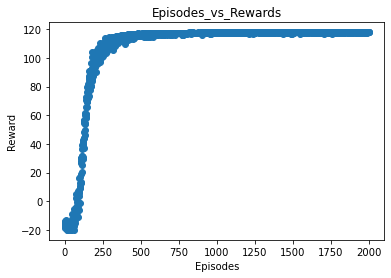

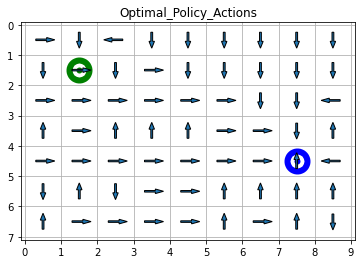

Average number of times goal was reached:  1864.9  representing 93.245 %
Average episode number in which the agent was able to learn:  133.15


In [6]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.3
discount_rate = 0.98
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v1_wnw.jpg"
filepath_optimal_policy = "optimal_policies/v1_wnw.jpg"
filepath_rewards = "rewards/rewards_v1_wnw.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 2
    learning_rate = 0.5
    discount_rate = 0.98
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005

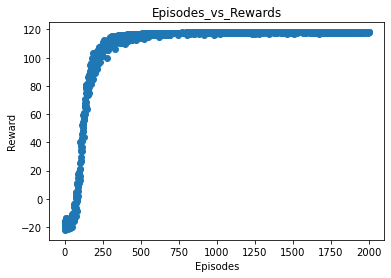

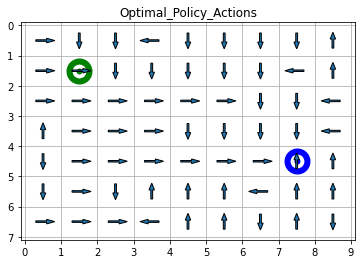

Average number of times goal was reached:  1871.62  representing 93.58099999999999 %
Average episode number in which the agent was able to learn:  130.15


In [7]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.5
discount_rate = 0.98
max_exploration_rate = 1
min_exploration_rate = 0.01
exploration_decay_rate = 0.005

filepath_e_vs_r = "episodes_vs_reward/v2_wnw.jpg"
filepath_optimal_policy = "optimal_policies/v2_wnw.jpg"
filepath_rewards = "rewards/rewards_v2_wnw.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 3
    learning_rate = 0.2
    discount_rate = 0.95
    max_exploration_rate = 1
    min_exploration_rate = 0.003
    exploration_decay_rate = 0.05

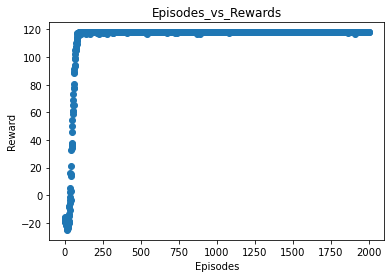

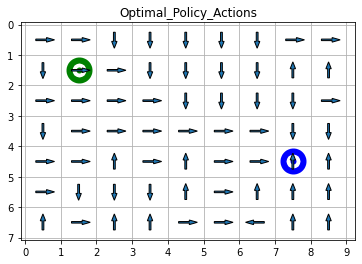

Average number of times goal was reached:  1952.23  representing 97.61149999999999 %
Average episode number in which the agent was able to learn:  62.56


In [8]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.003
exploration_decay_rate = 0.05

filepath_e_vs_r = "episodes_vs_reward/v3_wnw.jpg"
filepath_optimal_policy = "optimal_policies/v3_wnw.jpg"
filepath_rewards = "rewards/rewards_v3_wnw.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Version 4
    learning_rate = 0.2
    discount_rate = 0.95
    max_exploration_rate = 1
    min_exploration_rate = 0.003
    exploration_decay_rate = 0.5

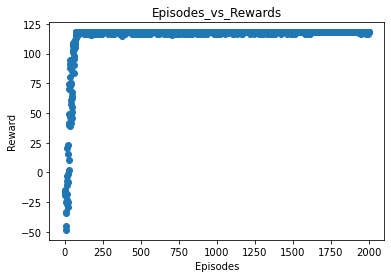

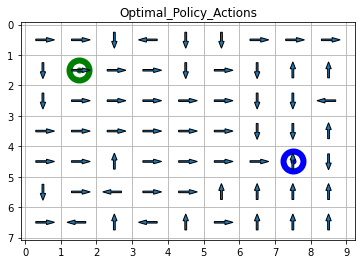

Average number of times goal was reached:  1966.44  representing 98.322 %
Average episode number in which the agent was able to learn:  49.18


In [9]:
num_episodes = 2000
max_steps_per_episode = 100

learning_rate = 0.2
discount_rate = 0.95
max_exploration_rate = 1
min_exploration_rate = 0.003
exploration_decay_rate = 0.5

filepath_e_vs_r = "episodes_vs_reward/v4_wnw.jpg"
filepath_optimal_policy = "optimal_policies/v4_wnw.jpg"
filepath_rewards = "rewards/rewards_v4_wnw.npy"

rewards_avg, q_table,num_times_goal_reached = rl(num_episodes, max_steps_per_episode, learning_rate, discount_rate, max_exploration_rate, min_exploration_rate, exploration_decay_rate)
plot_episodes_vs_rewards(num_episodes, rewards_avg, filepath_e_vs_r)
plot_optimal_policy(q_table, filepath_optimal_policy)
save_rewards(filepath_rewards, rewards_avg)
print("Average number of times goal was reached: ", np.mean(num_times_goal_reached) ,f" representing {(np.mean(num_times_goal_reached)/num_episodes) *100} %")
print("Average episode number in which the agent was able to learn: ", get_max_reward_avg_episode(rewards_avg))

#### Experiments Comparation Table:

In [12]:
import pandas as pd
results = pd.read_csv('experiment-results-rl-no-wind.csv')
results

,version,learning_rate,discount_rate,min_exploration_rate,max_exploration_rate,exploration_rate_decay_rate,goal_reached_percentage,avg_episode_learn
0,1,0.3,0.98,0.010,1,0.005,93.24%,133.15
1,2,0.5,0.98,0.010,1,0.005,93.50%,130.15
2,3,0.2,0.95,0.003,1,0.050,97.60%,62.56
3,4,0.2,0.95,0.003,1,0.500,98.30%,49.18


#### Rewards Vs Episodes Comparation

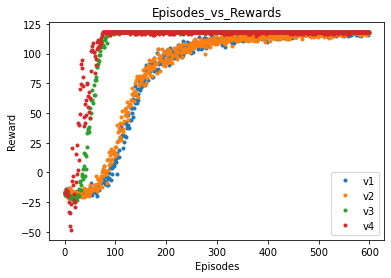

In [13]:
r_v1 = load_rewards("rewards/rewards_v1_wnw.npy")
r_v2 = load_rewards("rewards/rewards_v2_wnw.npy")
r_v3 = load_rewards("rewards/rewards_v3_wnw.npy")
r_v4  = load_rewards("rewards/rewards_v4_wnw.npy")

n=600
x = [i for i in range(0,n)]
y_v1 = np.mean(r_v1, axis=0)[:n]
y_v2 = np.mean(r_v2, axis=0)[:n]
y_v3 = np.mean(r_v3, axis=0)[:n]
y_v4 = np.mean(r_v4, axis=0)[:n]

plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y_v1,'.')
plot.plot(x, y_v2,'.')
plot.plot(x, y_v3,'.')
plot.plot(x, y_v4,'.')

plot.title("Episodes_vs_Rewards")
plt.legend(['v1','v2','v3','v4'])
plt.savefig("episodes_vs_reward/comparation_no_wind.jpg")
plt.show()

    We can observe the same tendency as in the experiments made with wind. In experiments 3 and 4, the agent learns faster how to reach the goal, in less than 100 episodes.
    In experiments 1 and 2 the agent learns a bit slower, taking about 400 episodes to learn to reach the goal.
    As we saw in experiments with wind, a bigger exploration decay rate helps the agent learn faster.

### Comparing # of episodes needed to learn to reach Goal state

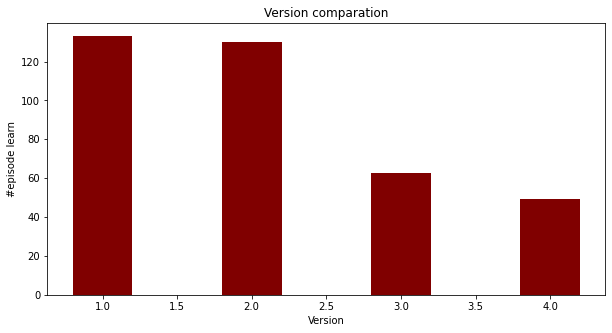

In [14]:
#inspired in https://www.geeksforgeeks.org/bar-plot-in-matplotlib/
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10, 5))

# creating the bar plot
plt.bar(results['version'],results['avg_episode_learn'], color ='maroon',
		width = 0.4)

plt.xlabel("Version")
plt.ylabel("#episode learn")
plt.title("Version comparation")
plt.show()


    As we can observe, the agent learned faster in version 4 of the experiments made, which means increasing the exploration decay rate gave us better results, resulting in a higher number of episodes the agent was able to reach the goal, representing 98.3% of all episodes. This tells us that the agent is learning optimally. 
    Now we will compare the optimal policies of the 4 experiments made:

### Optimal Policy comparation

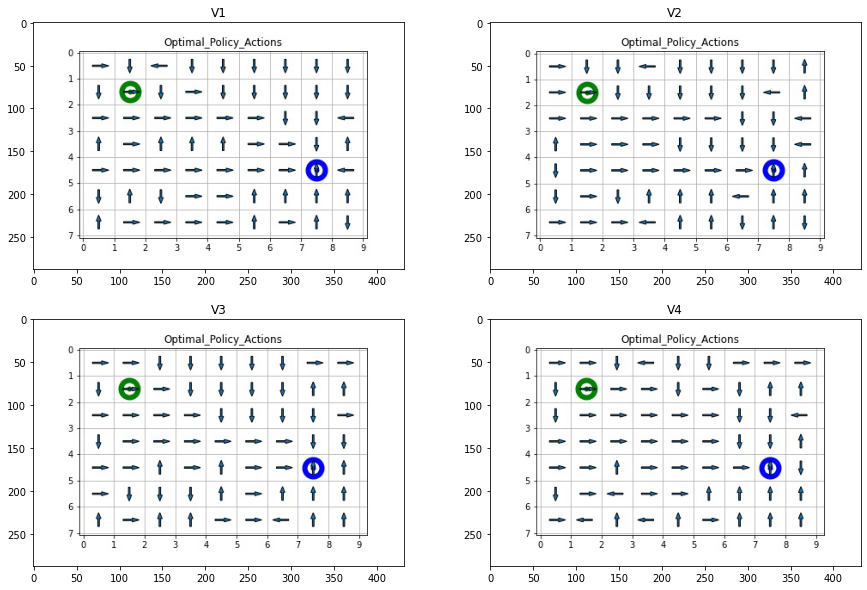

In [11]:
img1 = plt.imread('optimal_policies/v1_wnw.jpg')
img2 = plt.imread('optimal_policies/v2_wnw.jpg')
img3 = plt.imread('optimal_policies/v3_wnw.jpg')
img4 = plt.imread('optimal_policies/v4_wnw.jpg')

plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.imshow(img1)
plt.title('V1')
#plt.show()

plt.subplot(2,2,2)
plt.imshow(img2)
plt.title('V2')
# plt.show()

plt.subplot(2,2,3)
plt.imshow(img3)
plt.title('V3')
# plt.show()

plt.subplot(2,2,4)
plt.imshow(img4)
plt.title('V4')
plt.show()

    Without wind, we see that the agent finds an optimal path towards the goal more easily. We can observe that columns 3, 4, and 5, which were the previous wind columns, have the best action selected as DOWN for experiments 1 and 3. This might be because, even though there is no wind, the agent could still choose to go UP and get out of the gameboard, which would be penalized, so the best action learned is still DOWN. As for experiments 2 and 4, columns 4 and 5 in row 0 have the best action as DOWN too, but column 3 chooses left. Since there is no wind, and the agent would not get out of the gameboard by going left, it can still be considered an optimal action.
    If we follow the path from Harry(green circle) towards Sirius(blue circle) in all policies, following the arrows, we can see that all 4 versions get to Sirius in an optimum way, even though they choose different paths. It is interesting to see how the agent can learn differently, reaching different q-table values, but still all of them are efficient, and not one can be considered better than the other, since they all choose a path that reaches the goal state. Anyway, as we observed previously, version 4 of the experiments made learned faster.